In [58]:
#Importing the libraries of interest
%matplotlib ipympl

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

np.printoptions(suppress=True)
pd.options.mode.chained_assignment = None  # default='warn'
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import auc, roc_auc_score, roc_curve, confusion_matrix, accuracy_score

In [59]:
#Reading in the file of interest
coviddata= pd.read_csv('/Users/Godfred King/Desktop/Tableau/COVID-19/Covid Data.csv')
coviddata.columns

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'DATE_DIED', 'INTUBED',
       'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU'],
      dtype='object')

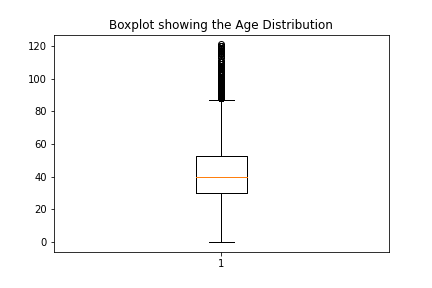

In [60]:
plt.figure()
#plt.hist(coviddata['AGE'], bins=20);
plt.boxplot(coviddata['AGE']);
plt.title('Boxplot showing the Age Distribution');

In [61]:
coviddata= coviddata[coviddata['AGE']<100]
coviddata= coviddata.reset_index()

In [62]:
pd.value_counts(coviddata['USMER'])

2    662784
1    385583
Name: USMER, dtype: int64

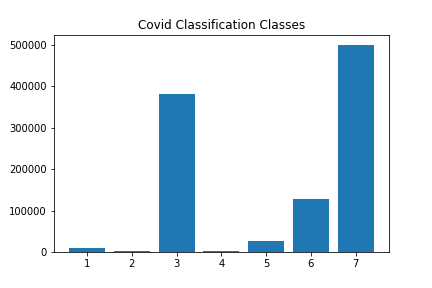

In [63]:

classes= pd.value_counts(coviddata['CLASIFFICATION_FINAL'])
plt.figure()
plt.bar(classes.index, classes.values)
plt.title('Covid Classification Classes');

<bound method IndexOpsMixin.value_counts of 0    656441
1    391926
Name: Covid_Patient, dtype: int64>

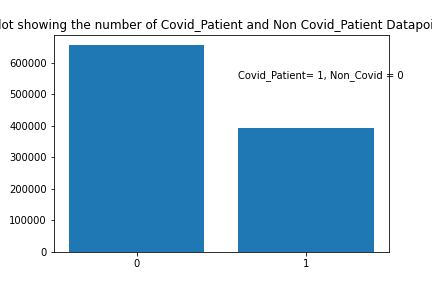

In [64]:
#Creating a Column for those who are Covid_Patient and those who are not
coviddata['Covid_Patient']= coviddata['CLASIFFICATION_FINAL'].apply(lambda x: 1 if x<4 else 0)
#Creating a new column to determine those who died 1 for death and 0 for alive
coviddata['Died']= coviddata['DATE_DIED'].apply(lambda x: 0 if x=='9999-99-99' else 1)

coviddata['Covid_Patient']= coviddata['Covid_Patient'].apply(lambda x: 1 if x>0 else 0)
classes= pd.value_counts(coviddata['Covid_Patient'])
plt.figure()
plt.bar(classes.index, classes.values)
plt.xticks([0,1]);
plt.title('Plot showing the number of Covid_Patient and Non Covid_Patient Datapoints')
plt.annotate('Covid_Patient= 1, Non_Covid = 0',(0.6,550000))
classes.value_counts

In [ ]:
coviddata['REAL_DATES']= pd.to_datetime(coviddata['DATE_DIED'], errors='coerce');
coviddata=coviddata.rename({'HIPERTENSION':'HPT'}, axis=1);
coviddata['PREGNANT']= coviddata['PREGNANT'].apply(lambda x:3 if x== 97 or x==98 else x);


In [66]:


pd.value_counts(coviddata['Died'])

0    971459
1     76908
Name: Died, dtype: int64

Text(0.5, 1.0, 'Male Pregnanicies')

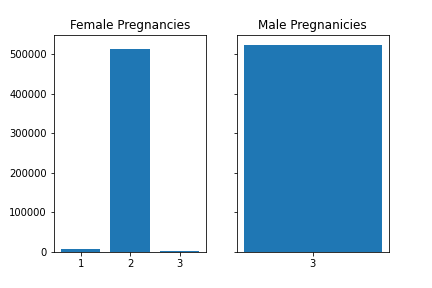

In [67]:
pregnant_females=coviddata[coviddata['SEX']==1]
pregnant_males= coviddata[coviddata['SEX']==2]
females= pd.value_counts(pregnant_females['PREGNANT'])
males= pd.value_counts(pregnant_males['PREGNANT'])

females
fig, (ax1,ax2)=plt.subplots(1,2, sharey=True)
plt.xticks([1,2,3])
ax1.bar(females.index, females.values)
ax1.set_title('Female Pregnancies')
ax2.bar(males.index, males.values)
ax2.set_title('Male Pregnanicies')

Males were coded as 2 and Females were coded as 1 in this particular dataset

It makes sense that all of the values for males when it comes to pregnancies will be missing because obviously males cannot get pregnant.

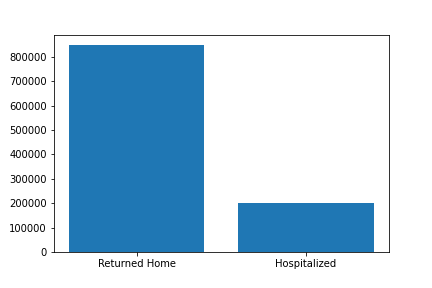

In [68]:
hosp_stay= pd.value_counts(coviddata['PATIENT_TYPE'])
hosp_stay
plt.figure()
plt.bar(hosp_stay.index, hosp_stay.values)
plt.xticks([1,2],['Returned Home','Hospitalized']);


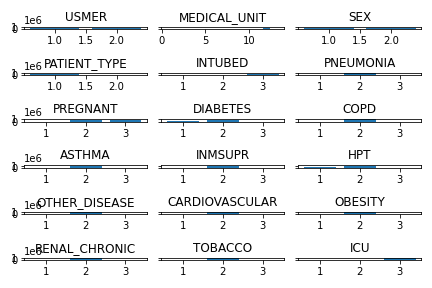

In [69]:

columns=[
'USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'INTUBED',
       'PNEUMONIA', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HPT', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC',
       'TOBACCO','ICU']

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,a9),(ax10,ax11,ax12),(ax13,ax14,ax15),(ax16,ax17,ax18))= plt.subplots(6,3, sharey=True, tight_layout=True)
fig_axes= list(fig.axes)
np.printoptions(suppress=True)
for i in range(len(columns)):
       coviddata[columns[i]]= coviddata[columns[i]].apply(lambda x: 3 if x== 97 or x==98 or x==99 else x )
       distribution= pd.value_counts(coviddata[columns[i]])
       fig_axes[i].bar(distribution.index, distribution.values)
       fig_axes[i].set_title(columns[i])
       #fig_axes[i].bar_label(fig_axes[i].containers[0],label_type='edge', rotation=90)


Coded all of the missing values as 3 for each of the predictors to see the amount of missing data that is present in the data set. Apart from pregnancy which has some amount of data missing, it looks like for most for the predictors the amount of missing data is not really much. 
For a dataset with about a million rows, I believe the best course of action will be remove those missing values from our data set. 
Missing Values for INTUBED and ICU are all going to be coded as NO because from literature, only a small percentage of COVID patients get intubated or admitted into the ICU

Most of the missing data in the pregnancy column are actually structually missing data for the men. In that men cannot get pregnant and so there was no point trying to gather any data for their pregnancy status. 
I think one solution going to write a function to check if the particular row in question is for a male patient and if that is the case we will jjust impute that missing variable as no because again, males cannot be pregnant. 
Also, I think it makes sense for females below the age of 15 to have missing values for their pregnancy status because, you do not expect young females around that age to be pregnant. 

We also want to encode Yes in the binary columns as 1 and No as 0. Missing values remain at 3

In [70]:
def modified_pregnancy(frame=coviddata):
    '''Checks every row in the dataset to see whether the Pregnant column is missing
        i.e value there is equal to 3, then checks to see whether that particular row is that 
        of a male that is Sex=2, if so we replace the pregnant column with 2,
        Also converts females less than 15  whose pregnancy status is missing to also not pregnant
        '''
    for i in range(len(frame)):
        if frame['PREGNANT'][i]==3:
            if frame['SEX'][i]==2:
                frame.loc[i,'PREGNANT']=2
            elif frame['SEX'][i]==1 and frame['AGE'][i]>15:
                frame.loc[i, 'PREGNANT']=2     
        else:
                continue
    
    return frame


def binary (frame):
    '''Converts all of the columns binary columns to 0s and 1s
    However for patient type, 0 represents Hospitalization and 1 represent returned home
    '''
    columns=['SEX','USMER','PATIENT_TYPE','PNEUMONIA','DIABETES','COPD','ASTHMA','INMSUPR','HPT', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC',
       'TOBACCO','ICU','INTUBED']
    for column in columns:
        if column == 'ICU' or column=='INTUBED':
            frame[column]= frame[column].apply(lambda x:1 if x==1 else 0)
        else:    
            frame[column]= frame[column].apply(lambda x: 1 if x==1 else(0 if x==2 else x) )
    return frame


In [71]:
coviddata=binary(modified_pregnancy())


We are going to defined AT Risk as patients who are susceptible to the extreme effects of the Virus. So patients who died, or were intubated or were admitted into the ICU

In [72]:
coviddata['AT_RISK'] = coviddata['Died'] + coviddata['INTUBED'] + coviddata['ICU']
coviddata['AT_RISK'] = coviddata['AT_RISK'].apply(lambda x: 1 if x > 0 else 0) 
pd.value_counts(coviddata['AT_RISK'])

0    958652
1     89715
Name: AT_RISK, dtype: int64

In [95]:
def covid_char(frame):
    '''This function takes a dataframe filters the data for those who had coronavirus of some kind
    Then for each of the columns that could indicate risk factors, we find the percentage of those who
    have coronavirus and those who do not. 
    Returns a dataframe of the Columns of the dataframe as the row index and the percentages as the columns    
    '''
    global risk_factors
    risk_factors=['PNEUMONIA','DIABETES','COPD','ASTHMA','INMSUPR','HPT', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC',
       'TOBACCO']
    frame= frame[frame['AT_RISK']==1]
    final_list= []
    for factor in risk_factors:
        frame[factor]= frame[factor].apply(lambda x: 3 if x==97 or x==98 or x==99 else x);
        values= pd.value_counts(frame[factor]);
        #CHeck to make sure we are making the right calculation here. 
        val_list=[(values.index[idx],values.values[idx]) for idx in values.index[:2]];
        
        final_list.append((factor,(val_list[1][1]/len(frame))*100));
       
    
 

    return pd.DataFrame(final_list)
    



In [96]:
new_frame=covid_char(coviddata);
new_frame


,0,1
0,PNEUMONIA,70.215683
1,DIABETES,35.174720
2,COPD,4.971298
3,ASTHMA,1.985175
4,INMSUPR,3.514462
5,HPT,39.760352
6,OTHER_DISEASE,6.029092
7,CARDIOVASCULAR,5.741515
8,OBESITY,22.379758
9,RENAL_CHRONIC,7.027810


This frame contains the percentage of persons who had the risk factors out of the total number of individuals with coronavirus
So out of the people who had some amount of coronavius, 70.22% of them had Pneumonia which means Pneumonia was relatively common 
among the coronavirus patient.

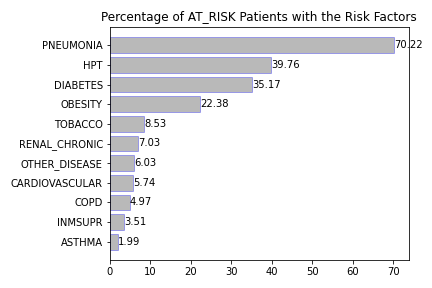

In [97]:
new_frame= new_frame.rename({0:'Risk Factor',1:'Percentage of Covid Patient'}, axis=1)
new_frame= new_frame.sort_values('Percentage of Covid Patient')
xvalues=range(0, len(new_frame))
plt.figure()
barg=plt.barh(xvalues, new_frame['Percentage of Covid Patient'],alpha=0.3,color=(0.1,0.1,0.1,0.1),edgecolor='blue')
plt.yticks(xvalues, new_frame['Risk Factor'],rotation=0)
plt.bar_label(barg,label_type='edge', rotation=0,fmt='%.2f')
plt.title('Percentage of AT_RISK Patients with the Risk Factors')
plt.tight_layout()


In [76]:

modeldata= coviddata[['SEX','PNEUMONIA','AGE','DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
                    'HPT', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC','TOBACCO','PATIENT_TYPE','USMER','MEDICAL_UNIT'
                    ,'AT_RISK']]


[modeldata.drop(modeldata[modeldata[factor]==3].index, inplace=True) for factor in risk_factors]
print('The total number of rows which were deleted from the dataframe are {}'.format(len(coviddata)-len(modeldata)))
print('The total number of rows we have after eliminating the missing values are {}'.format(len(modeldata)))


The total number of rows which were deleted from the dataframe are 23405
The total number of rows we have after eliminating the missing values are 1024962


Training and Building of the Random Forest
Plan
1. Build a Model with the Dummy Classifier
2. Build a Model with the Base Random Forest Classifier
3. Balance the classes for the training Data using SMOTE algorithm 
4. Build a refined Model using the new training data
5. Get the important features in the forest
6. Compute the confusion matrix, AUC score and ROC curve


In [77]:
x= modeldata[risk_factors+['AGE','SEX','PATIENT_TYPE','USMER','MEDICAL_UNIT']]
y= modeldata['AT_RISK']
pd.value_counts(modeldata['AT_RISK'])

0    937734
1     87228
Name: AT_RISK, dtype: int64

There is an imbalance with the classes.

In [78]:
X_train, X_test, y_train, y_test= train_test_split(x,y,train_size=0.8,random_state=42)


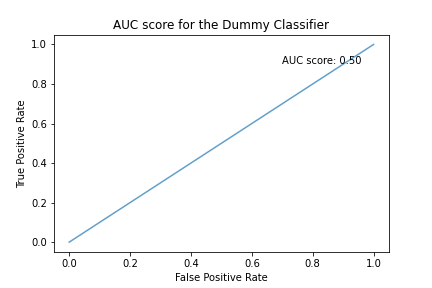

In [79]:
#Building the Dummy Classifier first. 
dumclass= DummyClassifier(strategy='most_frequent')
dumclass.fit(X_train, y_train)
dum_class_predictions= dumclass.predict(X_test)


fpr, tpr,_ = roc_curve(y_test, dum_class_predictions)
auc_sc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, alpha=0.7)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC score for the Dummy Classifier')
plt.annotate('AUC score: {:.2f}'.format(auc_sc),(0.7,0.9));

In [80]:
#Building the new 
baserandom= RandomForestClassifier()
baserandom.fit(X_train, y_train)
basepredict=baserandom.predict(X_test)

# fpr, tpr,_ = roc_curve(y_test, basepredict)

# auc_sc= auc(fpr, tpr)
# plt.figure()
# plt.plot(fpr, tpr, alpha=0.7)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('AUC score for the Base Random Classifier')
# plt.annotate('AUC score: {:.2f}'.format(auc_sc),(0.7,0.9));



In [81]:


print(accuracy_score(y_test, basepredict)*100)
print(roc_auc_score(y_test, basepredict)*100)

92.33729932241589
72.89265549545782


In [82]:
#Getting the parameters that are currently in use
from pprint import pprint
print('These are the parameters that are currently in use \n')
pprint(baserandom.get_params())

These are the parameters that are currently in use 

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [83]:
#Using the SMOTE oversampling algorithm on the training data to deal with the imbalance of classes 
oversamp= SMOTE()
over_X, over_Y= oversamp.fit_resample(X_train, y_train)
print(pd.value_counts(over_Y))

0    750011
1    750011
Name: AT_RISK, dtype: int64


In [84]:
#Building a refined Model after performing SMOTE on the training data
refmodel= RandomForestClassifier()
refmodel.fit(over_X, over_Y)
refpredictions= refmodel.predict(X_test)

In [85]:

print(accuracy_score(y_test, refpredictions)*100)
print(roc_auc_score(y_test, refpredictions)*100)

89.3957354641378
86.23680201218995


There was a slight improvement in the performance of the model after applying the SMOTE algorithm for balancing out the classes.

In [86]:
#Trying to get the most important features in the model
importance= list(baserandom.feature_importances_)
features= list(baserandom.feature_names_in_)
feature_importance= [(feature, round(importance,2)) for feature,importance in zip(features, importance)]
feature_importance= sorted(feature_importance, key=lambda x:x[1], reverse=True)
[print('Feature: {}  Importance: {}'.format(x[0],x[1]))for x in feature_importance];

Feature: AGE  Importance: 0.31
Feature: PATIENT_TYPE  Importance: 0.31
Feature: PNEUMONIA  Importance: 0.18
Feature: MEDICAL_UNIT  Importance: 0.06
Feature: DIABETES  Importance: 0.02
Feature: HPT  Importance: 0.02
Feature: COPD  Importance: 0.01
Feature: ASTHMA  Importance: 0.01
Feature: INMSUPR  Importance: 0.01
Feature: OTHER_DISEASE  Importance: 0.01
Feature: CARDIOVASCULAR  Importance: 0.01
Feature: OBESITY  Importance: 0.01
Feature: RENAL_CHRONIC  Importance: 0.01
Feature: TOBACCO  Importance: 0.01
Feature: SEX  Importance: 0.01
Feature: USMER  Importance: 0.01


For the factors that were considered as risk factors, Pneumonia and Diabetes were the only ones used in the bulding of the forest. The rest of the risk factors had little to no influence in the building of the model.

In [87]:
#Trying to get the most important features in the model
importance= list(refmodel.feature_importances_)
features= list(refmodel.feature_names_in_)
feature_importance= [(feature, round(importance,2)) for feature,importance in zip(features, importance)]
feature_importance= sorted(feature_importance, key=lambda x:x[1], reverse=True)
[print('Feature: {}  Importance: {}'.format(x[0],x[1]))for x in feature_importance];

Feature: PATIENT_TYPE  Importance: 0.52
Feature: PNEUMONIA  Importance: 0.21
Feature: AGE  Importance: 0.14
Feature: MEDICAL_UNIT  Importance: 0.04
Feature: DIABETES  Importance: 0.02
Feature: HPT  Importance: 0.02
Feature: SEX  Importance: 0.01
Feature: USMER  Importance: 0.01
Feature: COPD  Importance: 0.0
Feature: ASTHMA  Importance: 0.0
Feature: INMSUPR  Importance: 0.0
Feature: OTHER_DISEASE  Importance: 0.0
Feature: CARDIOVASCULAR  Importance: 0.0
Feature: OBESITY  Importance: 0.0
Feature: RENAL_CHRONIC  Importance: 0.0
Feature: TOBACCO  Importance: 0.0


Text(0.5, 1.0, 'Confusion Matrix for the Base Model')

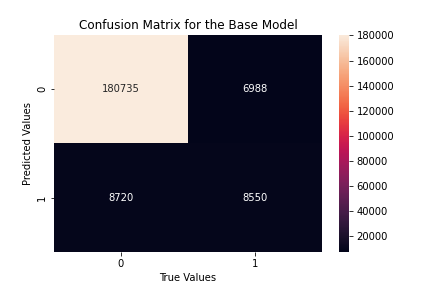

In [88]:
#Bulding a Confusion Matrix
confusion= confusion_matrix(y_test, basepredict)
plt.figure()
sns.heatmap(confusion, annot=True,fmt='g')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix for the Base Model')

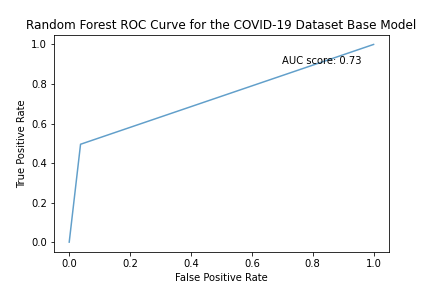

In [89]:
#Plotting the ROC curve and showing the AUC score for the Base Model 


fpr, tpr,_ = roc_curve(y_test, basepredict)
auc_sc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, alpha=0.7)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve for the COVID-19 Dataset Base Model')
plt.annotate('AUC score: {:.2f}'.format(auc_sc),(0.7,0.9));

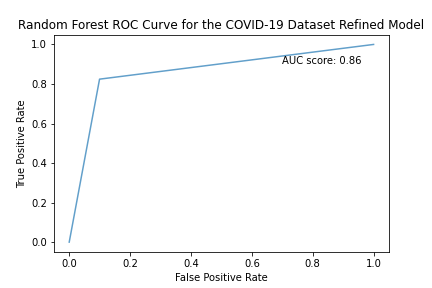

In [90]:
#Plotting the ROC curve and showing the AUC score for the Refined Model 
fpr, tpr,_ = roc_curve(y_test,refpredictions )
auc_sc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, alpha=0.7)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve for the COVID-19 Dataset Refined Model')
plt.annotate('AUC score: {:.2f}'.format(auc_sc),(0.7,0.9));

Text(0.5, 1.0, 'Confusion Matrix for the Refined Model')

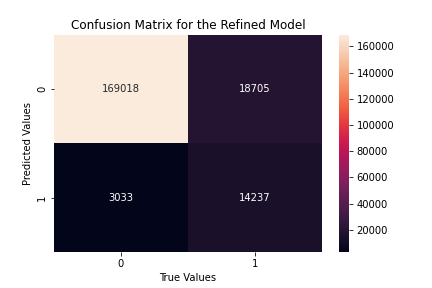

In [91]:
plt.figure()
confref= confusion_matrix(y_test, refpredictions)
sns.heatmap(confref, annot=True,fmt='g')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix for the Refined Model')